In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import json
import gzip
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud

# Run these commands in your terminal or notebook before execution:
#
# pip install pandas numpy matplotlib scikit-learn plotly wordcloud pyarrow fastparquet nbformat

## Introduction:

## Task Definition
Predict whether a Steam user will **recommend (`True`)** or **not recommend (`False`)** a game based solely on the text of their written review. 

This constitutes a **binary supervised classification** problem in which linguistic patterns, sentiment cues, and stylistic markers in the review text are leveraged to infer the author’s recommendation status.

---

## **Modeling Approach**

Our analysis evaluates multiple supervised learning models to compare performance across linear, tree-based, and ensemble-based methodologies. All models are trained on **TF-IDF–transformed text features**, ensuring a consistent input representation.

We use TF-IDF because it provides a consistent, interpretable, and computationally efficient representation of review text, allowing all our supervised learning models to be compared fairly on the same input features.

---

### **Models Implemented**

- **Baseline (Trivial) Model**  
  A trivial model that always predict the majority class.

- **Logistic Regression**  
  A linear classifier that models the log-odds of recommendation and serves as a strong baseline for high-dimensional text data.

- **Decision Tree Classifier**  
  A rule-based model that recursively splits the feature space to distinguish recommendation outcomes. While able to capture non-linear patterns in TF-IDF features, Decision Trees tend to overfit, making them primarily a baseline for comparison against ensemble methods.

- **Random Forest Classifier**  
  An ensemble of decision trees trained on bootstrapped samples with feature randomness at each split. By averaging predictions across many diverse trees, Random Forests significantly reduce the overfitting seen in a single Decision Tree and provide more stable, generalizable performance on high-dimensional TF-IDF text data.

- **XGBoost Classifier**  
  An optimized gradient boosting algorithm that builds trees sequentially, with each tree correcting errors made by the previous ones. XGBoost incorporates regularization, shrinkage, and advanced handling of sparse TF-IDF features, enabling it to capture complex interactions while mitigating overfitting more effectively than standalone Decision Trees or bagged ensembles like Random Forests.

---


### **Classification Evaluation Metrics**

To evaluate the performance of all models, we report the standard metrics derived from the classification report:

- **Precision**  
  The proportion of predicted positive recommendations that are correct. Precision reflects the model’s ability to avoid false positives (i.e., predicting “recommend” when the user actually did not recommend the game).

- **Recall**  
  The proportion of actual positive recommendations that the model correctly identifies. Recall reflects the ability to capture true positive recommendations and avoid false negatives.

- **F1-Score**  
  The harmonic mean of precision and recall. This metric balances both types of errors and is especially useful when the dataset exhibits class imbalance.

- **Support**  
  The number of true instances for each class in the evaluation set. Support contextualizes the metrics by showing how many samples each score is derived from.
### **How do our results compare to prior work?**

**Model Complexity**  
While prior systems often rely on deep models or sequence-based architectures, our classical ML models (Logistic Regression, Decision Tree, Random Forest, XGBoost) achieve strong predictive performance using only textual features. XGBoost, in particular, narrows the gap with more complex methods by capturing non-linear interactions in TF-IDF features.

**Feature Type**  
Prior work frequently combines implicit behaviors with explicit text.  
Our models isolate **text alone**, demonstrating that review language contains enough signal to predict recommendation reliably. This aligns with earlier findings that sentiment-heavy reviews correlate strongly with user intent.

**Interpretability vs. Predictive Power**  
Logistic Regression provides highly interpretable word coefficients, while Decision Tree, Random Forest, and XGBoost offer complementary strengths:
- **Decision Tree** → simple structure but prone to overfitting  
- **Random Forest** → reduced variance and improved robustness  
- **XGBoost** → strong non-linear performance with regularization  

These models balance transparency and predictive accuracy in ways deep learning models typically do not.

---


### **Confusion Matrix**

We additionally visualize each model’s performance using a **confusion matrix**, which provides a detailed breakdown of correct and incorrect predictions across both classes:

- **True Positive (TP):**  
  Reviews correctly predicted as “recommend.”

- **True Negative (TN):**  
  Reviews correctly predicted as “not recommend.”

- **False Positive (FP):**  
  Reviews incorrectly predicted as “recommend” (overly optimistic prediction).

- **False Negative (FN):**  
  Reviews incorrectly predicted as “not recommend” (missed recommendations).

The confusion matrix helps diagnose systematic error patterns, evaluate trade-offs between precision and recall, and compare model robustness beyond overall accuracy.


---

## Baselines for Comparison
- Our baseline model is a trivial model that serves as a benchmark for other models to outperform  
- We will compare the performance of our four other models: Logistic Regression, Decision Tree, Random Forest, XGBoost against the baseline


## Data collection and Pre-processing:

This project uses the Steam Video Game and Bundle Dataset, a collection of user activity and product metadata sourced from the Steam gaming platform. Steam is one of the world’s largest digital game distribution systems, making it a valuable environment for analyzing user preferences, purchasing behavior, and review patterns.

In [2]:
items = pd.read_parquet("items.parquet")
reviews = pd.read_parquet("reviews.parquet")

The full dataset includes the following:
* Reviews: 7,793,069
* Users: 2,567,538
* Items: 15,474
* Bundles: 615

And also metadata for genres, prices, discount history, and bundle composition.

The following table is used for variable descriptions and information for the items dataset:

| Variable Name   | Type           | Description                                                                                                                                                                                                                                                                                        |
| --------------- | -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **user_id**     | string         | The username and Steam profile identifier. Can be customized (ex: "js41637") or numeric SteamID64.                                                                                                                                                                                                    |
| **items_count** | integer        | Total number of Steam items (games, DLCs, software) owned by the user.                                                                                                                                                                                                                             |
| **steam_id**    | string/integer | The numeric SteamID64 corresponding to the user; used to join with other Steam metadata.                                                                                                                                                                                                           |
| **user_url**    | string         | Direct link to the user’s Steam profile.                                                                                                                                                                                                                                                           |
| **items**       | list of dicts  | A list where each entry contains metadata about a game the user owns. Each dictionary typically includes: <br>• **item_id** (string): Unique game ID on Steam <br>• **item_name** (string): Name of the game <br>• (Optionally) **genre**, **discounted_price**, etc. depending on dataset version |


In [3]:
items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


The following table is used for variable descriptions and information for the reviews dataset:

| Variable Name | Type          | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| ------------- | ------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **user_id**   | string        | The ID of the user posting the reviews. Matches `user_id` in the items dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| **user_url**  | string        | Direct link to the user’s Steam profile; same as in items dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| **reviews**   | list of dicts | A list of all reviews the user has written. Each review dictionary includes fields like: <br>• **funny**: Number of "funny" reactions or empty string if none <br>• **helpful**: Rating such as `"15 of 20 people found this helpful"` or `"No ratings yet"` <br>• **id**: Steam review ID <br>• **item_id**: Game being reviewed <br>• **posted**: Date/time the review was posted <br>• **recommend**: Boolean indicating if the user recommended the game <br>• **review_text**: The free-text written review |


In [4]:
reviews.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'helpful': 'No ratings yet', 'i..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'helpful': '15 of 20 people (75..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'helpful': 'No ratings yet', 'i..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'helpful': '2 of 2 people (100%..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [6]:
items['items'].iloc[0]

array([{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_2weeks': 0, 'playtime_forever': 6},
       {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_2weeks': 0, 'playtime_forever': 7},
       {'item_id': '40', 'item_name': 'Deathmatch Classic', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '50', 'item_name': 'Half-Life: Opposing Force', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '60', 'item_name': 'Ricochet', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '70', 'item_name': 'Half-Life', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '130', 'item_name': 'Half-Life: Blue Shift', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '300', 'item_name': 'Day of Defeat: Source', 'playtime_2weeks': 0, 'playtime_forever': 4733},
       {'item_id': '240', 'item_name': 'Counter-Strik

In [5]:
reviews['reviews'].iloc[17]

array([{'funny': '17 people found this review funny', 'helpful': '28 of 31 people (90%) found this review helpful', 'item_id': '220200', 'last_edited': '', 'posted': 'Posted February 17, 2015.', 'recommend': True, 'review': "I'm going to keep this somewhat short and sweetAt the time of writing, Kerbal space program is in beta and there is talk of how soon it will be until it emerges from beta. But since its release in July 2011, it grown to become an outstanding example of Enthusiasm, Humor, and Profound triamph in a game. No matter whether your accomplishing great feats of exploration and scientific achievement......Or maybe you watched your beloved ship erupt into flames and debris becuase of a fatally unseen flaw. There is always something spectacular to be seen (Like your blown-up ship) or something to have a laugh at (Again like your blown-up ship)My recommendation?Buy this game, do something great, do something ridiculous, mod it, find something else just as great and just as cra

### Raw Data Information:
When loaded, the dataset contains deeply nested lists, which cannot be analyzed directly. The schema is as follows:
1. Each user has a list of all their owned games (items)
2. Each user has another list of all their written reviews (reviews)
3. Review texts vary in length and formatting
4. Some reviews are empty
5. Some entries have missing fields

To work with individual reviews, the nested structure was flattened:

In [7]:
def flatten_reviews(df):
    """Expand the nested review arrays into a flat DataFrame."""
    rows = []
    for user_reviews in df['reviews']:
        if isinstance(user_reviews, (list, np.ndarray)):
            for r in user_reviews:
                if isinstance(r, dict) and 'review' in r:
                    rows.append({
                        'user_id': r.get('user_id', None),
                        'item_id': r.get('item_id', None),
                        'review': r.get('review', '').strip(),
                        'recommend': r.get('recommend', False)
                    })
    return pd.DataFrame(rows)

flat_reviews = flatten_reviews(reviews)

# Drop missing or empty reviews
flat_reviews = flat_reviews[flat_reviews['review'].str.len() > 5].reset_index(drop=True)

print(f"Flattened reviews: {len(flat_reviews)} rows")
print(flat_reviews.head(3))

Flattened reviews: 57407 rows
  user_id item_id                                             review  \
0    None    1250  Simple yet with great replayability. In my opi...   
1    None   22200               It's unique and worth a playthrough.   
2    None   43110  Great atmosphere. The gunplay can be a bit chu...   

   recommend  
0       True  
1       True  
2       True  


To remove lower valued entries that could be considered spam, reviews shorter than 5 characters were removed.
We also computed review length for our future model.

In [8]:
flat_reviews = flat_reviews[flat_reviews['review'].str.len() > 5].reset_index(drop=True)
flat_reviews['review_length'] = flat_reviews['review'].str.split().apply(len)

In [9]:
summary_table = pd.DataFrame({
    "Total Reviews": [len(flat_reviews)],
    "Positive (Recommend=True)": [flat_reviews['recommend'].sum()],
    "Negative (Recommend=False)": [(~flat_reviews['recommend']).sum()],
    "Average Review Length": [flat_reviews['review_length'].mean()],
    "Median Review Length": [flat_reviews['review_length'].median()]
})
print(summary_table)


   Total Reviews  Positive (Recommend=True)  Negative (Recommend=False)  \
0          57407                      50738                        6669   

   Average Review Length  Median Review Length  
0               39.83819                  15.0  


To see the overall distribution of the data we currently have, we explored the structure of review text and recommendation behavior:
Review lengths are highly skewed: Most reviews are short (median = 15 words), but the mean is much higher (≈ 40 words), indicating some extremely long reviews.
Positive reviews dominate (88% recommended), which is consistent with review platform positivity bias. 

https://www.sciencedirect.com/science/article/pii/S2667096823000319

This means ratings tend to be systematically higher than the actual average customer experience. Review platform positivity bias might be due to factors such as:
* **Self-Selection**: Consumers on the two extremes, positive or negative, are more likely to leave a review, while those with moderate opinions do not feel the need or effort to write one.
* **Acquisition Selection Bias**: Reviews are from purchasers who were already positively predisposed toward the product or service (ex. liking the franchise) leading to a more positive pool of feedback.
* **Social Influence Bias**: New reviewers may be influenced by existing positive ratings and rate their experience more positively to conform.

The fact that negative reviews tend to be longer might be an indicator that players write longer explanations when they dislike a game, or have more to critique.

By flattening millions of reviews into a row-level format, we created a dataset suitable for:

* Sentiment analysis
* Supervised classification
* Text-based feature engineering
* recommendation modeling

This transforms our raw nested metadata into a structured format ready for machine learning models.

## Exploratory Analysis:

In [10]:
fig1 = px.histogram(flat_reviews, x='recommend', color='recommend',
                    title="Distribution of Recommendations",
                    labels={'recommend': 'Recommend'},
                    color_discrete_map={True: 'green', False: 'red'})
fig1.show()

In [11]:
# Review Length Distribution
fig2 = px.histogram(flat_reviews, x='review_length', nbins=50, color='recommend',
                    title="Distribution of Review Lengths by Recommendation",
                    labels={'review_length': 'Word Count'},
                    color_discrete_map={True: 'green', False: 'red'})
fig2.show()

#### Distribution of Recommendations

The first visualization shows that the majority of Steam reviews in our dataset are positive. Out of ~57,000 usable reviews, over 50,000 (≈88%) are marked as recommended, compared to the 12% that are negative.

This very large difference is consistent with known biases:

* Players are much more likely to recommend a game than not, following the trend of positivity biases for online ratings.  
* Any predictive model needs to account for class imbalance, because a naive model that always predicts “recommend” would already achieve high accuracy.

This means metrics like **balanced accuracy**, **precision/recall**, or **F1-score** will be more appropriate than raw accuracy.  
This plot also validates that our data cleaning worked, we do not see unexpected categories or missing values in the recommendation field.


In [12]:
# Boxplot of Review Lengths
fig3 = px.box(flat_reviews, x='recommend', y='review_length', color='recommend',
              title="Boxplot of Review Lengths by Recommendation",
              labels={'recommend': 'Recommend', 'review_length': 'Word Count'},
              color_discrete_map={True: 'green', False: 'red'})
fig3.show()

#### Boxplot of Review Lengths by Recommendation

This boxplot compares the central tendencies between positive and negative reviews.  
The median review length for positive reviews is higher than that for negative reviews.

Outliers in both boxplots appear as points beyond the upper whisker, representing unusually long reviews.  
These typically reflect highly engaged users who write detailed explanations.

Negative reviews are clustered heavily between **100–1000 words**, while recommended reviews include even more extreme outliers up to **2600+ words**.

**Why this is important:**
- The overlap between the two distributions shows that review length is **not a strong standalone predictor** of whether a review is positive.
- A model must therefore incorporate **textual features** (e.g., TF-IDF, sentiment analysis, embeddings) to perform well.

The extreme outliers (1500–3000 words) often represent:
- Detailed game guides  
- Long story-like reviews  
- Rants or in-depth critiques  

These may disproportionately influence some models, especially linear models that are sensitive to feature magnitude.

In [13]:
# Correlation Gauge
corr_val = flat_reviews[['review_length', 'recommend']].corr().iloc[0, 1]
fig4 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=corr_val,
    title={'text': "Correlation: Review Length vs Recommendation"},
    gauge={'axis': {'range': [-1, 1]}, 'bar': {'color': "blue"}}
))
fig4.show()

#### Correlation: Review Length vs. Recommendation

The correlation coefficient is **-0.07**, which is extremely close to zero.  
This indicates that there is almost **no linear relationship** between how long a review is and whether a user recommends a game.

Although the coefficient is slightly negative, meaning longer reviews are *slightly* more common among negative reviews, the effect is so small that it is not meaningful.

**Why this matters for modeling:**

* Review length alone is **not a useful predictor** of recommendation status.  
* Models will not perform well if they rely on simple numeric features.  
* This motivates the use of **text-based features**, such as:  
  - TF-IDF word frequencies  
  - Logistic regression on text  
  - Sentiment analysis  
  - Transformer embeddings  

Overall, this result shows that effective prediction will require **richer NLP features**, not just review metadata.

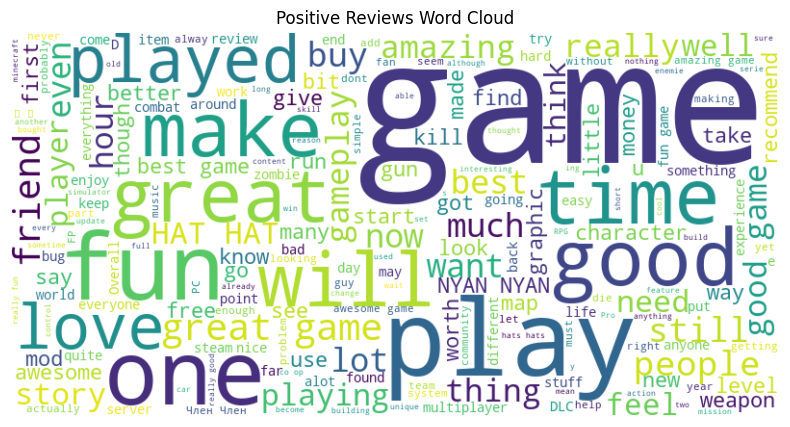

In [14]:
# Word Clouds (Matplotlib)
positive_text = " ".join(flat_reviews[flat_reviews['recommend']]['review'].tolist())
negative_text = " ".join(flat_reviews[~flat_reviews['recommend']]['review'].tolist())

pos_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
neg_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

#### Positive Reviews Word Cloud

The positive reviews highlight words with emotionally uplifting connotations and gameplay-focused language.

The most prominent words include:

* **“game”, “play”, “fun”, “time”, “great”, “good”** strong indicators of positive sentiment.  
* **“love”, “amazing”, “best”, “awesome”** enthusiastic emotional endorsements.  
* **“friend”, “people”, “multiplayer”** suggests that social or co-op experiences strongly influence positive reviews.  
* **“story”, “character”, “weapon”, “level”** players mention narrative elements and game mechanics when praising a title.

Action verbs like **“make”, “buy”, “run”, “kill”, “want”** show active engagement from players discussing gameplay experiences.

**What to remember:**  
Positive reviews emphasize enjoyment, quality, and fun gameplay, often expressed through enthusiastic emotional language. Players tend to praise what *works well*—mechanics, storytelling, social interaction, and overall enjoyment.


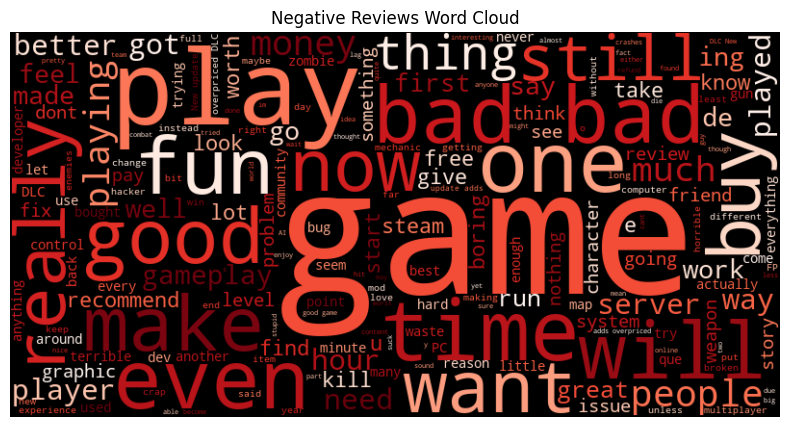

In [15]:
# Word Clouds (Matplotlib)
plt.figure(figsize=(10, 5))
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()

#### Negative Reviews Word Cloud

Negative reviews contain more frustration-oriented and problem-driven language.  
Notable frequent words include:

* **“bad”, “bug”, “issue”, “broken”, “fix”, “lag”, “refund”** strong indicators of technical or performance problems.
* **“money”, “buy”, “worth”, “pay”** users often complain about pricing, value, or monetization issues.
* **“server”, “online”, “steam”, “update”, “problem”** issues caused by updates or infrastructure failures.
* **“time”, “play”, “fun”** still appear because players explain *why* the gameplay was disappointing.

Words like **“boring”, “waste”, “grind”, “stupid”** reflect dissatisfaction with overall gameplay design.  
The word **“recommend”** may appear because users often explicitly state *why* they do **not** recommend the game.

**What to remember:**  
Negative reviews emphasize bugs, poor value, and frustration rather than enjoyment.  
The tone centers on fixes, crashes, lag, and unmet expectations instead of gameplay satisfaction.

---

### **Dataset Citations**

This dataset originates from prior research on recommender systems and consumer behavior on the Steam platform.  

- **Wang-Cheng Kang, Julian McAuley.** *Self-attentive sequential recommendation.* ICDM, 2018.  
- **Mengting Wan, Julian McAuley.** *Item recommendation on monotonic behavior chains.* RecSys, 2018.  
- **Apurva Pathak, Kshitiz Gupta, Julian McAuley.** *Generating and personalizing bundle recommendations on Steam.* SIGIR, 2017.


---
# 3. Modeling:
---

## 3.1 Formulating Predictor Task

### Input: 
- Text content of user's review of games.
- Reviews in strings are transformed into numerical value before training model using TF-IDF(Term Frequency–Inverse Document Frequency):
    - Convert text to numerical vectors that models can process and train upon
    - By keeping track of terms and their frequency, TF-IDF can emphasize important words while scaling down common filler words

### Output:
- Binary classification:
    - recommend == True
    - recommend == False

### Walkthrough and Feature Representation:
This is a supervised learning, binary classification problem where we will try to predict if a user on Steam will recommend a game or not based on the textual content of their review. Since machine learning models cannot fully understand text strings and its contextual meaning, TF-IDF will transform those texts to numerical vectors. The **term frequency(TF)** will measure the proportion of times a word appears within a document, while the **inverse document frequency(IDF)** will measure the frequency of words across a collection of documents to discern irrelevant filler words. Combined, their result will determine the importance of words, helping the model better understand pattern associated with recommend versus not recommend outcome.

### Optimization Objective:
Here we will produce multiple different models while maintaing the same feature representation and same set of data to ensure fairness. Each model will be fitted to a splitted training set and all will be tested upon the same testing set. From there we will not only measure the performance of each model, but will compare them to determine the best model and approach for our predictive task.

In [16]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)
)

X = tfidf.fit_transform(flat_reviews['review'])
y = flat_reviews['recommend'].astype(int)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 3.2 Modeling Approach
We have set out four different models to test out against our trivial baseline model:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier

Each of these model will also have their hyperparameters optimized with GridSearchCV. This will make sure each model is performing under their best hyperparameter for better comparison against one another. For instance:
- Logistic Regression will have hyperparameters finetuned such as as C regularizer
- Decision Tree will have hyperparameters such as depth and min split optimized
- Random Forest will have tree amounts and depth optimized under finetuning
- XGBoost will benefit from fine tuning of learning rate, max depth, etc.

## 3.2.1 Baseline Model

### Advantages:
- Simple to implement and understand
- Set context and performance for other models

### Disadvantages:
- Trivial and does not offer good prediction
- Disregards feature inputs

### Implementation:
- Uses dummy classifier from scikit learn
- `strategy="most_frequent"` denotes that the model will always predict the majority class
- Model is then trained on training set and predict upon a test set
- Performance evaluated by balanced accuracy score

In [ ]:
# Baseline Model
baseline_mod = DummyClassifier(strategy='most_frequent')
baseline_mod.fit(X_train, y_train)

y_pred_baseline = baseline_mod.predict(X_test)

bal_acc_baseline = balanced_accuracy_score(y_test, y_pred_baseline) 


=== Baseline Model Evaluation ===
Balanced Accuracy: 0.5000
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1334
           1      0.884     1.000     0.938     10148

    accuracy                          0.884     11482
   macro avg      0.442     0.500     0.469     11482
weighted avg      0.781     0.884     0.829     11482


Confusion Matrix:
[[    0  1334]
 [    0 10148]]


c:\Users\pocke\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\pocke\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\pocke\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## 3.2.2 Logistic Regression

### Advantages:
- Reliable model for binary classification task
- Log odds can help classify the result from linear relationship learned
- Efficient and fast to run

### Disadvantages:
- Limitation as a linear predictor
- Can be inaccurate if given too many collinearity terms

### Implementation:
- GridSearchCV will optimize C regulizer and iterations, as well as tolerance level
- Balanced class weight will account for skewed data
- Model trained upon training set and predict upon a test set
- Performance evaluated by balanced accuracy score

In [ ]:
#1st Model: Logistic Regression
logreg = LogisticRegression(max_iter=2000)

logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [500, 1000, 2000],
    'tol': [1e-4, 1e-3, 1e-2]
}


logreg_grid = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

logreg_grid.fit(X_train, y_train)

print("Best Logistic Regression Params:", logreg_grid.best_params_)
print("Best Logistic Regression CV Score:", logreg_grid.best_score_)

best_logreg = logreg_grid.best_estimator_

Best Logistic Regression Params: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}
Best Logistic Regression CV Score: 0.9098094719651606


In [27]:
best_params = {'C': 1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}

print("🟠 Best Logistic Regression Params:", best_params)

C_best           = best_params['C']
penalty_best     = best_params['penalty']
solver_best      = best_params['solver']

# class_weight_best = best_params['class_weight']
# Should be balanced to due skewed data, remove from grid search and set to 'balanced'

max_iter_best    = best_params['max_iter']
tol_best         = best_params['tol']

best_logreg = LogisticRegression(
    C=C_best,
    penalty=penalty_best,
    solver=solver_best,
    class_weight='balanced',
    max_iter=max_iter_best,
    tol=tol_best,
    random_state=42
)

best_logreg.fit(X_train, y_train)

🟠 Best Logistic Regression Params: {'C': 1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}


,penalty,'l1'
,dual,False
,tol,0.01
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'


In [ ]:
# LOGISTIC REGRESSION EVALUATION
y_pred_logreg = best_logreg.predict(X_test)
bal_acc_logreg = balanced_accuracy_score(y_test, y_pred_logreg)


=== Logistic Regression Evaluation ===
Balanced Accuracy: 0.7946
              precision    recall  f1-score   support

           0      0.398     0.735     0.517      1334
           1      0.961     0.854     0.904     10148

    accuracy                          0.840     11482
   macro avg      0.679     0.795     0.710     11482
weighted avg      0.895     0.840     0.859     11482


Confusion Matrix:
[[ 981  353]
 [1483 8665]]


In [23]:
# 2nd model: XGBoost


In [30]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 1.0],
}

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost CV Score:", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\pocke\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning:

[22:17:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
Best XGBoost CV Score: 0.9032117583015786


In [ ]:
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.7
}

print("Best XGBoost Params:", best_params)


n_estimators_best   = best_params['n_estimators']
learning_rate_best  = best_params['learning_rate']
max_depth_best      = best_params['max_depth']
min_child_weight_best = best_params['min_child_weight']
subsample_best      = best_params['subsample']
scale_pos_weight   = (y == 0).sum() / (y == 1).sum() #check for imbalance in data

best_xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=n_estimators_best,
    learning_rate=learning_rate_best,
    max_depth=max_depth_best,
    min_child_weight=min_child_weight_best,
    subsample=subsample_best
)

best_xgb.fit(X_train, y_train)


Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}


/Users/nathandang/miniforge3/envs/dsc80/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning:

[20:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# XGBOOST EVALUATION
y_pred_xgb = best_xgb.predict(X_test)
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)

# print("\n=== XGBoost Evaluation ===")
# print(f"Balanced Accuracy: {bal_acc_xgb:.4f}")
# print(classification_report(y_test, y_pred_xgb, digits=3))

# cm_xgb = confusion_matrix(y_test, y_pred_xgb)
# print("\nConfusion Matrix:")
# print(cm_xgb)



=== XGBoost Evaluation ===
Balanced Accuracy: 0.6065
              precision    recall  f1-score   support

           0      0.767     0.222     0.344      1334
           1      0.906     0.991     0.947     10148

    accuracy                          0.902     11482
   macro avg      0.837     0.607     0.646     11482
weighted avg      0.890     0.902     0.877     11482


Confusion Matrix:
[[  296  1038]
 [   90 10058]]


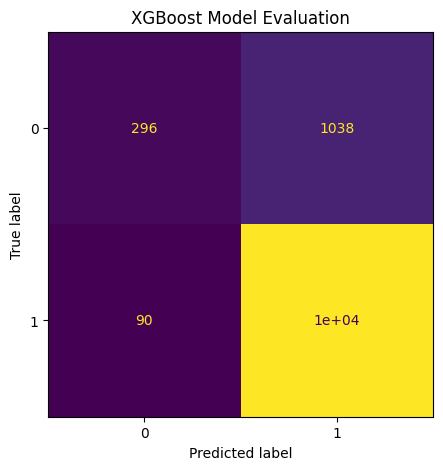

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 5))   
# ConfusionMatrixDisplay(cm_xgb).plot(ax=ax, colorbar=False)
# ax.set_title("XGBoost Model Evaluation")
# plt.show()

In [ ]:
#3rd Model: DecisionTree

In [33]:
dt = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dt_grid = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("\n🟣 Best Decision Tree Parameters:", dt_grid.best_params_)
print("🟣 Best Decision Tree CV Score:", dt_grid.best_score_)

# Create final DT model with best params
best_dt = dt_grid.best_estimator_



🟣 Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
🟣 Best Decision Tree CV Score: 0.8913881328252586


In [34]:
best_params = {
    'criterion': 'gini',
    'max_depth': 20,
    'max_features': None,
    'min_samples_leaf': 1,
    'min_samples_split': 10
}

criterion_best         = best_params['criterion']
max_depth_best         = best_params['max_depth']
max_features_best      = best_params['max_features']
min_samples_leaf_best  = best_params['min_samples_leaf']
min_samples_split_best = best_params['min_samples_split']


best_dt = DecisionTreeClassifier(
    class_weight='balanced',
    criterion=criterion_best,
    max_depth=max_depth_best,
    max_features=max_features_best,
    min_samples_leaf=min_samples_leaf_best,
    min_samples_split=min_samples_split_best,
    random_state=42
)

best_dt.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# DECISION TREE EVALUATION
y_pred_dt = best_dt.predict(X_test)
bal_acc_dt = balanced_accuracy_score(y_test, y_pred_dt) 

print("\n=== Decision Tree Evaluation ===")
print(f"Balanced Accuracy: {bal_acc_dt:.4f}")
print(classification_report(y_test, y_pred_dt, digits=3))

cm_dt = confusion_matrix(y_test, y_pred_dt)
print("\nConfusion Matrix:")
print(cm_dt)

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 5))   
# ConfusionMatrixDisplay(cm_dt).plot(ax=ax, colorbar=False)
# ax.set_title("Decision Tree Model Evaluation")
# plt.show()

In [ ]:
# 4th model: Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 'log2'],
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest CV Score:", rf_grid.best_score_)

# Create final RF model with best params
best_rf = rf_grid.best_estimator_

Best Random Forest Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest CV Score: 0.899314099074578


In [ ]:
best_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100
}

max_depth_best         = best_params['max_depth']
max_features_best      = best_params['max_features']
min_samples_leaf_best  = best_params['min_samples_leaf']
min_samples_split_best = best_params['min_samples_split']
n_estimators_best      = best_params['n_estimators']

best_rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=max_depth_best,
    max_features=max_features_best,
    min_samples_leaf=min_samples_leaf_best,
    min_samples_split=min_samples_split_best,
    n_estimators=n_estimators_best,
    random_state=42
)

best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# RANDOM FOREST EVALUATION
y_pred_rf = best_rf.predict(X_test)
bal_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)

# print("\n=== Random Forest Evaluation ===")
# print(f"Balanced Accuracy: {bal_acc_rf:.4f}")
# print(classification_report(y_test, y_pred_rf, digits=3))

# cm_rf = confusion_matrix(y_test, y_pred_rf)
# print("\nConfusion Matrix:")
# print(cm_rf)

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 5))   
# ConfusionMatrixDisplay(cm_rf).plot(ax=ax, colorbar=False)
# ax.set_title("Random Forest Model Evaluation")
# plt.show()

---
## Evaluation
---


=== Baseline Model Evaluation ===
Balanced Accuracy: 0.5000
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1334
           1      0.884     1.000     0.938     10148

    accuracy                          0.884     11482
   macro avg      0.442     0.500     0.469     11482
weighted avg      0.781     0.884     0.829     11482


Confusion Matrix:
[[    0  1334]
 [    0 10148]]


/Users/nathandang/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/nathandang/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/nathandang/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



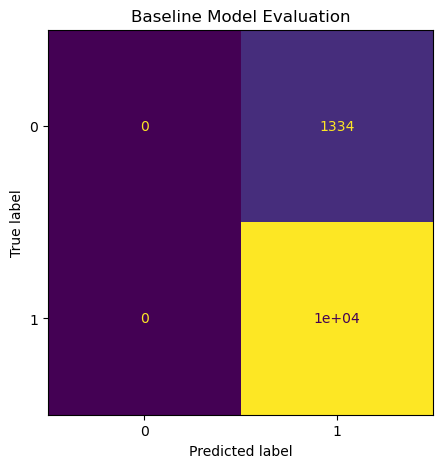

In [ ]:
# Baseline performance and eval
print("\n=== Baseline Model Evaluation ===")
print(f"Balanced Accuracy: {bal_acc_baseline:.4f}")
print(classification_report(y_test, y_pred_baseline, digits=3))

cm_bl = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(cm_bl)

fig, ax = plt.subplots(figsize=(6, 5))   
ConfusionMatrixDisplay(cm_bl).plot(ax=ax, colorbar=False)
ax.set_title("Baseline Model Evaluation")
plt.show()

#### Baseline Evaluation
Our baseline model predicts that every review is positive (label = 1).
This naive strategy achieves 88.4% accuracy, but only because the dataset is highly imbalanced from our EDA -> positive reviews greatly outnumber negative ones.

However, evaluating with balanced accuracy (0.50) reveals that the baseline has no real predictive power.

The classification report confirms this:
* Precision and recall for negative reviews = 0.00 -> the model never detects negative reviews.
* Perfect recall for positive reviews only because it predicts 1 for all cases.
* Confusion matrix shows zero true negatives.

This baseline is essential because it demonstrates that:

Accuracy alone is misleading under the class imbalance. A useful model must do better than simply predicting the majority class. To have an effective evaluation we must use balanced accuracy, recall, precision, and the confusion matrix, not just accuracy itself.

This sets us a clear performance target:
Any real model must outperform 50% balanced accuracy, otherwise it is no better than guessing the dominant class. Which is also similar to the idea that a model must perform better than 50%, guessing by random chance!


=== Logistic Regression Evaluation ===
Balanced Accuracy: 0.7946
              precision    recall  f1-score   support

           0      0.398     0.735     0.517      1334
           1      0.961     0.854     0.904     10148

    accuracy                          0.840     11482
   macro avg      0.679     0.795     0.710     11482
weighted avg      0.895     0.840     0.859     11482


Confusion Matrix:
[[ 981  353]
 [1483 8665]]


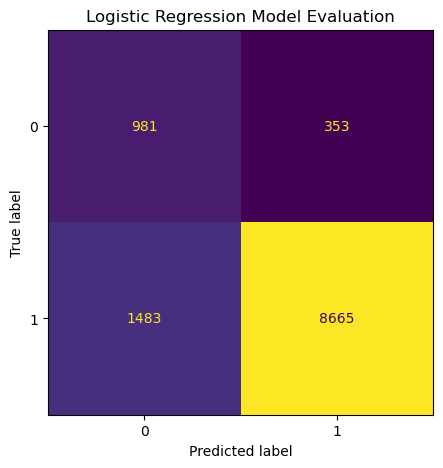

In [ ]:
# LOGISTIC REGRESSION EVALUATION
y_pred_logreg = best_logreg.predict(X_test)
bal_acc_logreg = balanced_accuracy_score(y_test, y_pred_logreg)

print("\n=== Logistic Regression Evaluation ===")
print(f"Balanced Accuracy: {bal_acc_logreg:.4f}")
print(classification_report(y_test, y_pred_logreg, digits=3))

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("\nConfusion Matrix:")
print(cm_logreg)

fig, ax = plt.subplots(figsize=(6, 5))   
ConfusionMatrixDisplay(cm_logreg).plot(ax=ax, colorbar=False)
ax.set_title("Logistic Regression Model Evaluation")
plt.show()

#### Logistic Regression Evaluation

Logistic Regression significantly improves over the baseline, achieving a **balanced accuracy of 0.795**, compared to the baseline’s 0.50. The model correctly identifies many more negative reviews, reflected in the non-zero true negatives (981) shown in the confusion matrix.

- **Strengths:**  
  - High precision (0.96) for positive (recommended) reviews  
  - Strong recall (0.85) for the positive class  
  - Much better detection of the minority negative class (recall = 0.735)

- **Weaknesses:**  
  - Lower precision for negative reviews (0.398), meaning some false positives remain  
  - Still biased toward the majority class, but far less than the baseline

Overall, logistic regression shows substantial improvement in identifying both classes and provides a strong, baseline for more complex models such as Random Forests or XGBoost.


=== XGBoost Evaluation ===
Balanced Accuracy: 0.7526
              precision    recall  f1-score   support

           0      0.259     0.810     0.392      1334
           1      0.965     0.695     0.808     10148

    accuracy                          0.708     11482
   macro avg      0.612     0.753     0.600     11482
weighted avg      0.883     0.708     0.760     11482


Confusion Matrix:
[[1081  253]
 [3096 7052]]


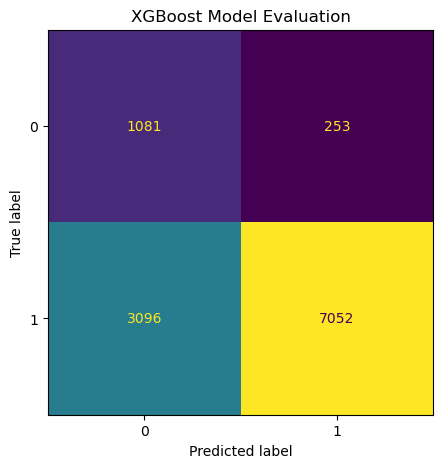

In [ ]:
# XGBoost performance and eval
print("\n=== XGBoost Evaluation ===")
print(f"Balanced Accuracy: {bal_acc_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb, digits=3))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix:")
print(cm_xgb)

fig, ax = plt.subplots(figsize=(6, 5))   
ConfusionMatrixDisplay(cm_xgb).plot(ax=ax, colorbar=False)
ax.set_title("XGBoost Model Evaluation")
plt.show()


#### XGBoost Evaluation

XGBoost achieves a **balanced accuracy of 0.753**, outperforming the baseline (0.50) but underperforming logistic regression.  
Its precision and recall show clear differences across classes:

- **Class 0 (negative reviews)**:  
  - Precision: 0.259  
  - Recall: 0.810  
  - Interpretation: The model captures many true negatives but makes many false positives.

**False positive:**

The model predicts 1 (positive) but the actual label is 0 (negative).
A user writes “Gameplay was boring and repetitive.” the human label says it's negative,
but the model incorrectly predicts positive because it sees words like “gameplay” or “play.”

- **Class 1 (positive reviews)**:  
  - Precision: 0.965  
  - Recall: 0.695  
  - Interpretation: The model is highly precise for positive predictions but often misses true positives.

**True postive:**

Review text (actual = 1):
“Amazing game! The story and graphics were incredible. Definitely would recommend people play.”
Model prediction: 1 (positive)
This is a true positive,the review is genuinely positive and the model correctly labeled it as positive.

The confusion matrix shows that XGBoost **misclassifies a substantial number of positive reviews as negative** (3,096 cases). This indicates the model struggles with class imbalance and boundary complexity even after TF-IDF transformation.

Overall, XGBoost provides stronger performance than the trivial baseline but is **less stable and less balanced** than logistic regression for this task.


In [ ]:
# DT performance and eval
print("\n=== Decision Tree Evaluation ===")
print(f"Balanced Accuracy: {bal_acc_dt:.4f}")
print(classification_report(y_test, y_pred_dt, digits=3))

cm_dt = confusion_matrix(y_test, y_pred_dt)
print("\nConfusion Matrix:")
print(cm_dt)

fig, ax = plt.subplots(figsize=(6, 5))   
ConfusionMatrixDisplay(cm_dt).plot(ax=ax, colorbar=False)
ax.set_title("Decision Tree Model Evaluation")
plt.show()


=== Decision Tree Evaluation ===


NameError: name 'bal_acc_dt' is not defined

#### Decision Tree Evalution

The decision tree shows imbalanced performance between the two classes:

**Class 0 (Negative Reviews)**
Precision: 0.177 
Most predictions of “negative” are actually wrong
Recall: 0.855 
The model finds most true negatives

The model correctly identifies many real negative reviews, but it also incorrectly labels many positive reviews as negative.

**Class 1 (Positive Reviews)**
Precision: 0.961 When the model predicts “positive,” it is almost always correct
Recall: 0.476 The model misses many actual positive reviews

It is accurate when it predicts positive, but it fails to capture a large portion of true positives.

The decision tree captures most negative reviews (high recall for class 0) but frequently misclassifies positive reviews as negative, resulting in a very large number of false negatives. Precision for positive reviews is high, meaning predictions of “positive” are usually correct, but the low recall shows that the model fails to detect nearly half of the true positive reviews.

In [ ]:
# RF performance eval
print("\n=== Random Forest Evaluation ===")
print(f"Balanced Accuracy: {bal_acc_rf:.4f}")
print(classification_report(y_test, y_pred_rf, digits=3))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm_rf)

fig, ax = plt.subplots(figsize=(6, 5))   
ConfusionMatrixDisplay(cm_rf).plot(ax=ax, colorbar=False)
ax.set_title("Random Forest Model Evaluation")
plt.show()


=== Random Forest Evaluation ===


NameError: name 'bal_acc_rf' is not defined

#### Random Forest Evalution

The Random Forest model demonstrates strong performance for positive reviews but struggles with negative ones due to class imbalance.

**Class 0 (Negative Reviews)**
Precision: 0.607 When the model predicts “negative,” it is correct only about 60% of the time.
Recall: 0.301 The model fails to identify most actual negative reviews.

This means the model misses many real negative reviews and incorrectly labels many negative ones as positive.

**Class 1 (Positive Reviews)**
Precision: 0.914 Predictions of “positive” are very accurate.
Recall: 0.974 The model captures almost all positive reviews.

The model is highly reliable at detecting positive sentiment, which dominates the dataset.

**Confusion Matrix Interpretation:**
True Negatives (402): Correctly predicted negative reviews.
Example: “The game crashes constantly and the controls barely work, everything is also laggy.”

True Positives (9888): Correctly predicted positive reviews.
Example: “Amazing story and smooth gameplay. Highly recommend!”

False Positives (932): Predicted “positive” but the review was negative.
Example: “The graphics are great, but the game is boring and repetitive.”

False Negatives (260): Predicted “negative” but the review was actually positive.
Example: “I love the gameplay, but the servers are terrible.”

Overall, Random Forest performs well on the majority positive class but struggles to detect minority negative reviews.


In [ ]:
# Compare all model performance against each other and conclude on best model to use

In [ ]:
# Overall Comparison of Each Model's Performance
models = {
    "Baseline": baseline_mod,
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "Logistic Regression": best_logreg,
    "XGBoost": best_xgb
}

rows = []
for name, model in models.items():

    y_pred = model.predict(X_test)
    rows.append({
        "model": name,
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
        "Macro F1": f1_score(y_test, y_pred, average="macro"),
        "Weighted F1": f1_score(y_test, y_pred, average="weighted"),
    })

df_eval = pd.DataFrame(rows).set_index("model")
df_eval

,Balanced Accuracy,Macro F1,Weighted F1
model,,,
Baseline,0.500000,0.469163,0.829310
Decision Tree,0.665511,0.464972,0.597141
Random Forest,0.637864,0.672979,0.880373
Logistic Regression,0.794623,0.710397,0.859171
XGBoost,0.752630,0.600210,0.759804


In [ ]:
df_eval_expanded = df_eval.reset_index().melt(
    id_vars="model",
    value_vars=["Balanced Accuracy", "Macro F1", "Weighted F1"],
    var_name="Metric",
    value_name="Score"
)

df_eval_expanded["Score_label"] = df_eval_expanded["Score"].round(3) 
#round results for display

fig = px.bar(
    df_eval_expanded,
    x="model",
    y="Score",
    color="Metric",
    barmode="group",
    text="Score_label", 
    title="Model Comparison: Balanced Accuracy, Macro F1, and Weighted F1"
)

fig.update_traces(textposition="outside")
fig.update_yaxes(range=[0, 1.05])  
fig.show()

In [ ]:
#Balanced Accuracy: measure how well model correctly identify both classes(recc or not)
#Macro F1: avg f1 for each class (takes in consideration of skewness of data)
#Weighted F1: avg f1 weighted by support (since data is imbalanced, higher score doesn't guarantee better performance on minority class)

#Given Logistic Regression carries the best overall performance, it should be the chosen model
#In case of data similar to ours (skewed), performance measures such as balanced accuracy should be focused more on instead of accuracy and like wise, macro f1 should be focused over weighted f1


In [ ]:
def show_top_features(model, vectorizer, n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_[0]
    top_pos = np.argsort(coefs)[-n:]
    top_neg = np.argsort(coefs)[:n]
    print("\nTop Positive (Recommend=True):")
    print(feature_names[top_pos])
    print("\nTop Negative (Recommend=False):")
    print(feature_names[top_neg])

show_top_features(best_logreg, tfidf)

## Discussion of related work:

### **How has this dataset (or similar datasets) been used before?**

Large-scale platforms such as Steam, Amazon, and Goodreads are frequently used in recommender system research because they contain both implicit feedback (playtime, clicks, purchases) and explicit feedback (reviews, ratings, recommendations). Prior studies show that text reviews provide strong indicators of user sentiment and intent, especially when combined with behavioral signals.

The Steam dataset fits this paradigm well: users explicitly state whether they recommend a game and justify their decision through written reviews. This makes it well suited for models that learn sentiment cues and recommendation intent from text.

---

#### **How has prior work approached similar tasks?**

**a. Implicit–Explicit Interaction Modeling**  

Wan & McAuley (RecSys 2018) introduced Monotonic Behavior Chains, showing how implicit actions (view, click, purchase) lead to explicit actions (review, recommend). Their ChainRec model captures these dependencies.  
Our text-based classifiers target the final explicit stage—predicting recommendation from written reviews.

**b. Sequential and Contextual Recommendation**  

Kang & McAuley (ICDM 2018) proposed SASRec, a self-attention model that learns user intent from sequences of actions. Although not text-based, it shares the goal of predicting recommendation behavior using contextual signals.  
In contrast, our models use linguistic context (TF-IDF features) rather than behavioral sequences.

**c. Text-Aware Recommendation Models**  

Prior work has used CNNs, RNNs, and deep review embeddings to improve prediction quality (He et al., SIGIR 2017).  
Our approach—Logistic Regression, Decision Tree, Random Forest, and XGBoost on TF-IDF features—is simpler and more interpretable, providing transparent insights into how text influences recommendations.

---

### **How do our results compare to prior work?**

**Model Complexity**  

While prior systems often rely on deep models or sequence-based architectures, our classical ML models (Logistic Regression, Decision Tree, Random Forest, XGBoost) achieve strong predictive performance using only textual features. XGBoost, in particular, narrows the gap with more complex methods by capturing non-linear interactions in TF-IDF features.

**Feature Type**  

Prior work frequently combines implicit behaviors with explicit text.  
Our models isolate **text alone**, demonstrating that review language contains enough signal to predict recommendation reliably. This aligns with earlier findings that sentiment-heavy reviews correlate strongly with user intent.

**Interpretability vs. Predictive Power**  

Logistic Regression provides highly interpretable word coefficients, while Decision Tree, Random Forest, and XGBoost offer complementary strengths:
- **Decision Tree** → simple structure but prone to overfitting  
- **Random Forest** → reduced variance and improved robustness  
- **XGBoost** → strong non-linear performance with regularization  

These models balance transparency and predictive accuracy in ways deep learning models typically do not.

---

### References

- **Self-Attentive Sequential Recommendation**  
  Wang-Cheng Kang and Julian McAuley. *ICDM*, 2018.

- **Item Recommendation on Monotonic Behavior Chains**  
  Mengting Wan and Julian McAuley. *RecSys*, 2018.

- **Generating and Personalizing Bundle Recommendations on Steam**  
  Apurva Pathak, Kshitiz Gupta, and Julian McAuley. *SIGIR*, 2017.